# Translate Felix's Location Criteria

In [4]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore",category=Warning)


import numpy as np
from matplotlib import pyplot as plt
import haversine
import scipy
import sys
sys.path.append('src/')

from notebook_functions import GradeLocErrorLatLon, GradeLocErrorMeters
from notebook_functions import calcRadius,calcDfStats, formatWS2021, plotLocZoomMeters,plotLocLatLonError,plotDepthLatLonError,plotDepthZoomMeters,latlon2meter, meters2deg, getProportionWS21
from notebook_functions import plotLocZoom5, plotDepthZoom8,plotDepthZoomMeters, plotLocZoomMeters, RemoveMagnitudes
from notebook_functions import latlon2meter


In [2]:


def GradeFelLocErrorLatLon(cat,verbose=0,plot=0):



    passed_num = 0
    grade_list = []
    grade_list_allevents = []

    cat_reloc_graded = pd.DataFrame()

    for clus in np.unique(cat.Cluster_2):

        if verbose:    
            print(f"Cluster {clus}")    

        df_cl = cat[cat.Cluster_2==clus]


        df_cl['depth_m'] = [1000 * d for d in df_cl.depth_km]

        depth_m = np.array(df_cl.depth_m)
        lon = np.array(df_cl.long)
        lat = np.array(df_cl.lat)        
        med_lat = np.median(df_cl.lat)

        ##get radius
        mag_max = np.max(df_cl.magnitude)
        r_m = calcRadius(mag_max+.1)


        ## Get loc errors
        minlocerr_km = 0.01; #% average min location error added to the rupture area (in km).
        minlocerr_m = minlocerr_km *1000      
        df_cl['locerr'] = [np.max([dX,dY,dZ,minlocerr_m]) for dX,dY,dZ in zip(df_cl.dX, df_cl.dY, df_cl.dZ)]

        dist_rows = []
        itake1 = 1

        for j in range(len(df_cl)):
            dist_epi_m       = [haversine.haversine([lat[j],lon[j]],[llat,llong],unit='m') for llat,llong in zip(df_cl.lat,df_cl.long)]
            dist_depth_m     = [(depth_m[j] - z) for z in df_cl.depth_m]
            dist_row         = [np.sqrt(d**2 + z**2) for d,z in zip(dist_epi_m, dist_depth_m)]

            if j==0:
                dist_rows = dist_row
            else:
                dist_rows = np.vstack([dist_rows,dist_row])


            inside = dist_rows < (r_m + df_cl.locerr.iloc[j])        

        # print(inside)
        if np.min(inside)==0:
            itake1=0
            passed = 0

        if(itake1==1):
            passed=1
            passed_num +=1













        if verbose:    
            print(f"Cluster {clus}; Passed? {passed}")

        grade_list.append(passed)
        [grade_list_allevents.append(passed) for a in range(len(df_cl))]          
        cat_reloc_graded = cat_reloc_graded.append(df_cl)



        if plot:


            fig, axes = plt.subplots(ncols=2,figsize=(6,4))
            plt.subplots_adjust(wspace=.5)

            axes[0].axis('equal')

            ## plot cluster
            plotLocLatLonError(df_cl,df_cl,fontsize=16,ax=axes[0])     


            plotDepthLatLonError(df_cl,df_cl,fontsize=16,ax=axes[1]) 
            axes[1].set_aspect(meters2deg(1,med_lat))


            ## plot cluster boundary 
            if passed:
                axes[0].set_title(f"Passed?:{passed}", color='green')

            else:
                axes[0].set_title(f"Passed?:{passed}", color='red')


            axes[1].set_title(f"Cl:{clus}")        

            axes[0].grid('on')
            axes[1].grid('on')        
            axes[0].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
            axes[1].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))        
            axes[0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))        


    cat_reloc_graded['Grade'] = grade_list_allevents

    print(len(cat),len(cat_reloc_graded[cat_reloc_graded.Grade==1]))

    cat_reloc_passed = cat_reloc_graded[cat_reloc_graded.Grade==1]
    return cat_reloc_passed


def GradeFelLocErrorLatLonRem(cat,verbose=0,plot=0, remove_events=1):



    passed_num = 0
    grade_list = []
    grade_list_allevents = []

    cat_reloc_graded = pd.DataFrame()

    for clus in np.unique(cat.Cluster_2):

        if verbose:    
            print(f"Cluster {clus}")    

        df_cl = cat[cat.Cluster_2==clus]


        df_cl['depth_m'] = [1000 * d for d in df_cl.depth_km]

        depth_m = np.array(df_cl.depth_m)
        lon = np.array(df_cl.long)
        lat = np.array(df_cl.lat)        
        med_lat = np.median(df_cl.lat)
        mag = np.array(df_cl.magnitude)

        ##get radius
        mag_max = np.max(df_cl.magnitude)
        r_m = calcRadius(mag_max+.1)


        ## Get loc errors
        minlocerr_km = 0.01; #% average min location error added to the rupture area (in km).
        minlocerr_m = minlocerr_km *1000      
        df_cl['locerr'] = [np.max([dX,dY,dZ,minlocerr_m]) for dX,dY,dZ in zip(df_cl.dX, df_cl.dY, df_cl.dZ)]

        dist_rows = []
        itake1 = 1

        for j in range(len(df_cl)):
            dist_epi_m       = [haversine.haversine([lat[j],lon[j]],[llat,llong],unit='m') for llat,llong in zip(df_cl.lat,df_cl.long)]
            dist_depth_m     = [(depth_m[j] - z) for z in df_cl.depth_m]
            dist_row         = [np.sqrt(d**2 + z**2) for d,z in zip(dist_epi_m, dist_depth_m)]            
            
            inside = dist_row < (calcRadius(mag[j]+.1) + df_cl.locerr.iloc[j]) 
            
                
            if j==0:
                inside_all = inside
            else:
                inside_all = np.vstack([inside_all,inside])


        # print(inside)
        if np.min(inside_all)==0:
            itake1=0
            passed = 0

        if(itake1==1):
            passed=1
            passed_num +=1













        if verbose:    
            print(f"Cluster {clus}; Passed? {passed}")

        grade_list.append(passed)
        [grade_list_allevents.append(passed) for a in range(len(df_cl))]          
        cat_reloc_graded = cat_reloc_graded.append(df_cl)



        if plot:


            fig, axes = plt.subplots(ncols=2,figsize=(6,4))
            plt.subplots_adjust(wspace=.5)

            axes[0].axis('equal')

            ## plot cluster
            plotLocLatLonError(df_cl,df_cl,fontsize=16,ax=axes[0])     


            plotDepthLatLonError(df_cl,df_cl,fontsize=16,ax=axes[1]) 
            axes[1].set_aspect(meters2deg(1,med_lat))


            ## plot cluster boundary 
            if passed:
                axes[0].set_title(f"Passed?:{passed}", color='green')

            else:
                axes[0].set_title(f"Passed?:{passed}", color='red')


            axes[1].set_title(f"Cl:{clus}")        

            axes[0].grid('on')
            axes[1].grid('on')        
            axes[0].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
            axes[1].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))        
            axes[0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))        


    cat_reloc_graded['Grade'] = grade_list_allevents

    print(len(cat),len(cat_reloc_graded[cat_reloc_graded.Grade==1]))

    cat_reloc_passed = cat_reloc_graded[cat_reloc_graded.Grade==1]
    return cat_reloc_passed



def removeOutside(df_cl):

    numFalse = 0

    (latc,longc) = (np.median(df_cl.lat),np.median(df_cl.long))
    df_cl_med_depth_m = np.median(df_cl.depth_km)*1000
    med_error = np.max([10,np.median(df_cl.locerr)])
    
    dist_row = [np.sqrt( latlon2meter((latc,longc),(df_cl.lat.iloc[i],df_cl.long.iloc[i]))**2 + (df_cl.depth_km.iloc[i]*1000-df_cl_med_depth_m)**2 ) for i in range(len(df_cl))]
    inside = np.array(dist_row) < dist + med_error
    df_cl_inside = df_cl[inside]
    numFalse = len(inside[inside==False])
    
    
def removeOutsideMeters(df_cl):

    numFalse = 0

    (Xc,Yc,Zc) = (np.median(df_cl.X),np.median(df_cl.Y),np.median(df_cl.Z))

    med_error = np.max([10,np.median(df_cl.locerr)])
    
    dist_row = [np.sqrt( (Xc-df_cl.X.iloc[i])**2 + (Yc-df_cl.Y.iloc[i])**2 + (Zc-df_cl.Z.iloc[i])**2 ) for i in range(len(df_cl))]
    
    inside = np.array(dist_row) < (dist + med_error)
    
    df_cl_inside = df_cl[inside]
    
    numFalse = len(inside[inside==False])    



#     print(numFalse)

    return df_cl_inside, numFalse


def removeOutsideMetersNoRID(df_cl):

    numFalse = 0
    
    (Xc,Yc,Zc) = (np.median(df_cl.X),np.median(df_cl.Y),np.median(df_cl.Z))

    med_error = np.max([10,np.median(df_cl.locerr)])
    
    dist_row = []
    
    for i in range(len(df_cl)):
        
        if df_cl.RID.iloc[i]=='0':
    
            dist_row.append(np.sqrt( (Xc-df_cl.X.iloc[i])**2 + (Yc-df_cl.Y.iloc[i])**2 + (Zc-df_cl.Z.iloc[i])**2 ))
        else:
            dist_row.append(0)
    
    inside = np.array(dist_row) < (dist + med_error)
    
    df_cl_inside = df_cl[inside]
    
    numFalse = len(inside[inside==False])    



#     print(numFalse)

    return df_cl_inside, numFalse


In [6]:
cat_NCSN = pd.read_csv('../data/catalogs/NCADDiff_5km_2019_500mFault_WS21.csv')




In [8]:
cat_reloc = pd.read_csv('../data/catalogs/reloc_cat_final_Rx0_1Stations_20230325.csv')

cat_reloc['timestamp'] = pd.to_datetime(cat_reloc[['year','month','day','hour','minute','second']])
cat_reloc['timestamp_index'] = pd.to_datetime(cat_reloc[['year','month','day','hour','minute','second']])
cat_reloc = cat_reloc.set_index('timestamp_index')

In [9]:
len(cat_reloc)

3158

In [10]:
cat_REQCA = formatWS2021('../data/catalogs/NCA_REPQcat_20210919_noMeta_v2.csv');



27674 repeater earthquakes in 7714  sequences


In [12]:

cat_WS21 = cat_NCSN[cat_NCSN.event_ID.astype('int').isin(list(cat_REQCA.event_ID))]

cat_WS21['Cluster_2'] = cat_WS21['RID']

len(cat_WS21),print(cat_WS21.columns)

Index(['Unnamed: 0', 'az', 'day', 'depth_km', 'dX', 'dY', 'dZ', 'hour', 'id',
       'lat', 'long', 'magnitude', 'minute', 'month', 'second', 'year',
       'event_ID', 'RID', 'dist_along_strike_km', 'radius', 'Cluster_2'],
      dtype='object')


(1024, None)

In [13]:
cat_WS21_reloc = cat_reloc[cat_reloc.event_ID.astype(str).isin(list(cat_WS21.event_ID))]

In [15]:
# cols = ['event_ID', 'lat', 'long', 'depth_km', 'X', 'Y', 'Z', 'dX', 'dY', 'dZ', 'YR', 'MO', 'DY', 'HR', 'MI', 'SC',\
# 'magnitude', 'NCCP', 'NCCS', 'NCTP','NCTS', 'RCC', 'RCT', 'RID']
# R_list = np.unique(cat_WS21.RID)
# hypo_cat_all = []

# for RR in R_list:
#     path_hypocat = f'../data/catalogs/RES_relocfiles/hypoDD.reloc.{RR}'
#     hypo_cat = pd.read_csv(path_hypocat,delim_whitespace=True,header=None,names=cols)
#     hypo_cat['RID'] = RR
#     hypo_cat['Cluster_2'] = RR
    
#     hypo_cat_all.append(hypo_cat)

# hypo_cat_all_df = pd.concat(hypo_cat_all,ignore_index=True)

In [16]:
# cols = ['event_ID', 'lat', 'long', 'depth_km', 'X', 'Y', 'Z', 'dX', 'dY', 'dZ', 'YR', 'MO', 'DY', 'HR', 'MI', 'SC',\
# 'magnitude', 'NCCP', 'NCCS', 'NCTP','NCTS', 'RCC', 'RCT', 'RID']

# # RR = 'R1.5592.6066.0'
# RR = 'R1.0916.4312.2'
# RR = 'R1.1335.516.1'
# RR = 'R1.1687.2612.0'
# RR = 'R1.2365.5644.0'
# RR = 'R1.0123.44.0'
# path_hypocat = f'../data/catalogs/RES_relocfiles/hypoDD.reloc.{RR}'
# hypo_cat = pd.read_csv(path_hypocat,delim_whitespace=True,header=None,names=cols)





# plotLocLatLonError(hypo_cat,hypo_cat)
# plt.figure()
# plotDepthLatLonError(hypo_cat,hypo_cat)
# ax = plt.gca()
# ax.set_aspect(1/111111)

# Location lat lon

In [17]:
cat = cat_reloc#[cat_reloc.Cluster_2==187]
# cat = cat_WS21
# cat = cat_noreloc
# cat = hypo_cat_all_df

len(cat)


3158

In [18]:
getProportionWS21(cat,cat_WS21)



0.970703125

In [19]:
cat.columns

Index(['event_ID', 'lat', 'long', 'depth_km', 'X', 'Y', 'Z', 'dX', 'dY', 'dZ',
       'year', 'month', 'day', 'hour', 'minute', 'second', 'magnitude', 'NCCP',
       'NCCS', 'NCTP', 'NCTS', 'RCC', 'RCT', 'RID', 'Cluster_2', 'NumStations',
       'CVr', 'timestamp'],
      dtype='object')

# (Simplest Version, meters - I used this one)

In [20]:
minlocerr_km = 0.01; #% average min location error added to the rupture area (in km).
minlocerr_m = minlocerr_km * 1000

cat['dHorz'] = [np.max([dX,dY,minlocerr_m]) for dX,dY in zip(cat.dX, cat.dY)]
cat['locerr'] = [np.max([dX,dY,dZ,minlocerr_m]) for dX,dY,dZ in zip(cat.dX, cat.dY, cat.dZ)]
cat['dHorz2'] = [np.max([dX,dY]) for dX,dY in zip(cat.dX, cat.dY)]

cat_crit_list = []
plot = 0
     
    
for enum,cl in enumerate(np.unique(cat.Cluster_2)):

    
    cat_clus = cat[cat.Cluster_2==cl]

    cat_clus.Cluster = cat_clus.Cluster_2

    X = np.array(cat_clus.X)
    Y = np.array(cat_clus.Y)
    Z = np.array(cat_clus.Z)

    itake1 = 1
    drad = []
    for j in range(len(X)):

        xj = cat_clus.X.iloc[j]
        yj = cat_clus.Y.iloc[j]
        zj = cat_clus.Z.iloc[j]
        locerrj = cat_clus.locerr.iloc[j]
        magj = cat_clus.magnitude.iloc[j]
        
        radj = calcRadius(magj + 0.1)
        
#         if dmag[j] > -10:
#             drad_j = srcrad(dmag[j] + dmage[j], stressdrop * 10) / 1000
#         else:
#             drad_j = rad
#         drad.append(drad_j)

        inside = np.sqrt((X - xj)**2 + (Y - yj)**2 + (Z - zj)**2) < (radj + locerrj)
        if not np.min(inside):
            itake1 = 0
            
    if itake1==1:
        cat_crit_list.append(cat_clus)
#         if plot:
#             fig, [ax,ax2] = plt.subplots(ncols=2,figsize=(8,4))
#             plt.subplots_adjust(wspace=1.5)

#             ax.set_title(cl)            

#             plotLocZoomMeters(cat_clus,cat_clus,ax=ax)
#             plotDepthZoomMeters(cat_clus,cat_clus,ax=ax2,fontsize=12)            
#             ax2.axis('equal')

#             ax.tick_params(color='g', labelcolor='g')
#             for spine in ax.spines.values():
#                 spine.set_edgecolor('g') 
#             ax2.tick_params(color='g', labelcolor='g')
#             for spine in ax2.spines.values():
#                 spine.set_edgecolor('g')            
        
    else:    
        
        if plot:
            fig, [ax,ax2] = plt.subplots(ncols=2,figsize=(8,4))
            plt.subplots_adjust(wspace=1.5)

            ax.set_title(cl)            

            plotLocZoomMeters(cat_clus,cat_clus,ax=ax)
            plotDepthZoomMeters(cat_clus,cat_clus,ax=ax2,fontsize=12)            
            ax2.axis('equal')

            ax.tick_params(color='red', labelcolor='red')
            for spine in ax.spines.values():
                spine.set_edgecolor('red') 
            ax2.tick_params(color='red', labelcolor='red')
            for spine in ax2.spines.values():
                spine.set_edgecolor('red') 
#             plt.savefig(f'../reports/figures/{cl}_reject.png')


                
cat_crit = pd.concat(cat_crit_list,ignore_index=True)
len(cat), len(cat_crit)


            

(3158, 772)

In [21]:
getProportionWS21(cat_crit,cat_WS21)




0.2890625

In [165]:
# cat_crit.to_csv('../data/catalogs/Rx16_test_1station_BSG_noWSloc.csv')

# With meters, removing outsiders

In [23]:
cat = cat_reloc#[cat_reloc.Cluster_2==187]
# cat = cat_WS21
# cat = cat_noreloc
# cat = hypo_cat_all_df

len(cat)
print(cat.columns)
getProportionWS21(cat,cat_WS21)

Index(['event_ID', 'lat', 'long', 'depth_km', 'X', 'Y', 'Z', 'dX', 'dY', 'dZ',
       'year', 'month', 'day', 'hour', 'minute', 'second', 'magnitude', 'NCCP',
       'NCCS', 'NCTP', 'NCTS', 'RCC', 'RCT', 'RID', 'Cluster_2', 'NumStations',
       'CVr', 'timestamp', 'dHorz', 'locerr', 'dHorz2'],
      dtype='object')


0.970703125

In [24]:
minlocerr_km = 0.01; #% average min location error added to the rupture area (in km).
minlocerr_m = minlocerr_km * 1000

cat['dHorz'] = [np.max([dX,dY,minlocerr_m]) for dX,dY in zip(cat.dX, cat.dY)]
cat['locerr'] = [np.max([dX,dY,dZ,minlocerr_m]) for dX,dY,dZ in zip(cat.dX, cat.dY, cat.dZ)]
cat['dHorz2'] = [np.max([dX,dY]) for dX,dY in zip(cat.dX, cat.dY)]

cat_crit_list = []
plot = 0
    
for enum,cl in enumerate(np.unique(cat.Cluster_2)):

    
    cat_clus00 = cat[cat.Cluster_2==cl]

    cat_clus00.Cluster = cat_clus00.Cluster_2
    
    cat_clus0 = RemoveMagnitudes(cat_clus00,verbose=0)
    
    if len(cat_clus0)>1:
    
        cat_clus,numFalse = removeOutsideMeters(cat_clus0) # remove outside clusters
        
        cat_clus.reset_index(inplace=True)


        if len(cat_clus)>1:



            X = np.array(cat_clus.X)
            Y = np.array(cat_clus.Y)
            Z = np.array(cat_clus.Z)

            itake1 = 1
            drad = []
            for j in range(len(X)):
                if cat_clus.RID.iloc[j]=='0':

                    xj = cat_clus.X.iloc[j]
                    yj = cat_clus.Y.iloc[j]
                    zj = cat_clus.Z.iloc[j]
                    locerrj = cat_clus.locerr.iloc[j]
                    magj = cat_clus.magnitude.iloc[j]

                    radj = calcRadius(magj + 0.1)

            #         if dmag[j] > -10:
            #             drad_j = srcrad(dmag[j] + dmage[j], stressdrop * 10) / 1000
            #         else:
            #             drad_j = rad
            #         drad.append(drad_j)

                    inside = np.sqrt((X - xj)**2 + (Y - yj)**2 + (Z - zj)**2) < 1*(radj + locerrj)
                else:
                    inside = 1

                if not np.min(inside):
                    itake1 = 0

            if itake1==1:
                cat_crit_list.append(cat_clus)
#                 if plot:
#                     fig, [ax,ax2] = plt.subplots(ncols=2,figsize=(8,4))
#                     plt.subplots_adjust(wspace=1.5)

#                     ax.set_title(cl)            

#                     plotLocZoomMeters(cat_clus,cat_clus,ax=ax)
#                     plotDepthZoomMeters(cat_clus,cat_clus,ax=ax2,fontsize=12)            
#                     ax2.axis('equal')

#                     ax.tick_params(color='g', labelcolor='g')
#                     for spine in ax.spines.values():
#                         spine.set_edgecolor('g') 
#                     ax2.tick_params(color='g', labelcolor='g')
#                     for spine in ax2.spines.values():
#                         spine.set_edgecolor('g')            

            else:    

                if plot:
                    fig, [ax,ax2] = plt.subplots(ncols=2,figsize=(8,4))
                    plt.subplots_adjust(wspace=1.5)

                    ax.set_title(cl)            

                    plotLocZoomMeters(cat_clus,cat_clus,ax=ax)
                    plotDepthZoomMeters(cat_clus,cat_clus,ax=ax2,fontsize=12)            
                    ax2.axis('equal')

                    ax.tick_params(color='red', labelcolor='red')
                    for spine in ax.spines.values():
                        spine.set_edgecolor('red') 
                    ax2.tick_params(color='red', labelcolor='red')
                    for spine in ax2.spines.values():
                        spine.set_edgecolor('red')
                        
                        
                    fig, [ax,ax2] = plt.subplots(ncols=2,figsize=(8,4))
                    plt.subplots_adjust(wspace=1.5)

                    ax.set_title(cl)            

                    plotLocZoomMeters(cat_clus0,cat_clus0,ax=ax)
                    plotDepthZoomMeters(cat_clus0,cat_clus0,ax=ax2,fontsize=12)            
                    ax2.axis('equal')

                    ax.tick_params(color='red', labelcolor='red')
                    for spine in ax.spines.values():
                        spine.set_edgecolor('red') 
                    ax2.tick_params(color='red', labelcolor='red')
                    for spine in ax2.spines.values():
                        spine.set_edgecolor('red')                        

        else:
    #         print('singleton')
            pass


            
cat_crit = pd.concat(cat_crit_list,ignore_index=True)
len(cat), len(cat_crit)


            

NameError: name 'dist' is not defined

In [430]:
# cat_crit.to_csv('../data/catalogs/Rx16_test2_1station_BSG_noWSloc_RemoveOutsidesAndMags.csv')



In [431]:
getProportionWS21(cat,cat_WS21)

0.970703125

In [432]:
getProportionWS21(cat_crit,cat_WS21)

0.7294921875

In [433]:
len(np.unique(cat_crit.Cluster_2))

394

In [393]:
# cat_WS21_crit = cat_crit

In [394]:
len(cat_crit[cat_crit.RID!='0']),len(cat_crit[cat_crit.RID=='0'])

(747, 1356)

0.7802734375

# More complicated way

In [188]:
# minlocerr_km = 0.01; #% average min location error added to the rupture area (in km).
# minlocerr_m = minlocerr_km * 1000

# cat['dHorz'] = [np.max([dX,dY,minlocerr_m]) for dX,dY in zip(cat.dX, cat.dY)]
# cat['locerr'] = [np.max([dX,dY,dZ,minlocerr_m]) for dX,dY,dZ in zip(cat.dX, cat.dY, cat.dZ)]
# cat['dHorz2'] = [np.max([dX,dY]) for dX,dY in zip(cat.dX, cat.dY)]



# cat_crit = pd.DataFrame()
# plot = 1
# ntype1 = 0

# for enum,cl in enumerate(np.unique(cat.Cluster_2)):
# # for enum,cl in enumerate(['R1.0123.44.0']):
    
#     cat_clus = cat[cat.Cluster_2==cl]

#     cat_clus.Cluster = cat_clus.Cluster_2

#     lon = np.array(cat_clus.long)
#     lat = np.array(cat_clus.lat)
#     med_lat = np.median(cat_clus.lat)
#     z_m = np.array(cat_clus.depth_km)*1000


#     itake1=1    

#     for j in range(len(cat_clus)):

#         latc = cat_clus.lat.iloc[j]
#         longc = cat_clus.long.iloc[j]
#         depthc_m = cat_clus.depth_km.iloc[j]*1000
#         mag = cat_clus.magnitude.iloc[j]
# #         dmag = cat_clus.dmag.astype(float).iloc[j]
# #         dmage = cat_clus.dmage.astype(float).iloc[j]



#         rad_m=(calcRadius(mag+0.1))

# #                 if dmag > -10 :
# #                     drad =(calcRadius(dmag+dmage)) 
# # #                     print(mag+0.1,dmag+dmage)
# #                 else:
# #                     print('k')
# #                     drad =rad_m;                
#         drad =rad_m;                

# #         print(drad)

#         max_dist = ((drad + cat_clus.locerr.iloc[j]))   


#         dist_row = [np.sqrt( latlon2meter((latc,longc),(lat[i],lon[i]))**2 + (z_m[i]-depthc_m)**2 ) for i in range(len(cat_clus)) if i!=j]

#         if j==0:
#             dist_rows = dist_row
#         else:
#             dist_rows = np.vstack([dist_rows,dist_row])


#     inside = np.array(dist_rows) <  max_dist

#     if np.min(inside)==0:
#         itake1=0


#     if(itake1==1):


#         ntype1= ntype1+1
#         cat_crit = cat_crit.append(cat_clus)


#         if plot:

#             fig, [ax,ax2] = plt.subplots(ncols=2,figsize=(8,4))
#             plt.subplots_adjust(wspace=1.5)

#             ax.set_title(enum)
#             plotLocLatLonError(cat_clus,cat_clus,ax=ax)
#             plotDepthLatLonError(cat_clus,cat_clus,ax=ax2,fontsize=12)             
#             ax2.set_aspect(meters2deg(1,med_lat))      
            
            
# #             plotLocZoom5(cat_clus,cat_clus,ax=ax)
# #             plotDepthZoom8(cat_clus,cat_clus,ax=ax2)
            


#             ax.tick_params(color='g', labelcolor='g')
#             for spine in ax.spines.values():
#                 spine.set_edgecolor('g')    




#     else:
#         if plot:  

#             fig, [ax,ax2] = plt.subplots(ncols=2,figsize=(8,4))
#             plt.subplots_adjust(wspace=1.5)

#             ax.set_title(cl)            
# #             plotLocZoom5(cat_clus,cat_clus,ax=ax)
# #             ax.scatter(longc,latc,marker='x',color='k',s=100)
# #             plotDepthZoom8(cat_clus,cat_clus,ax=ax2)
#             plotLocLatLonError(cat_clus,cat_clus,ax=ax)
#             plotDepthLatLonError(cat_clus,cat_clus,ax=ax2,fontsize=12)            
#             ax2.set_aspect(meters2deg(1,med_lat))
#             ax2.scatter(longc,depthc_m,marker='x',color='k',s=1000)


#             ax.tick_params(color='red', labelcolor='red')
#             for spine in ax.spines.values():
#                 spine.set_edgecolor('red')                      

# #             break


# print(ntype1)
# print(len(cat_crit))

In [87]:
getProportionWS21(cat_crit,cat_WS21)

0.6884765625

In [69]:
len(cat_crit[cat_crit.RID=='0']),len(cat_crit[cat_crit.RID!='0'])

(0, 708)

In [772]:
len(cat)

1024

In [774]:
cat.magnitude

15     NaN
21     NaN
28     NaN
29     NaN
30     NaN
        ..
3468   NaN
3473   NaN
3475   NaN
3478   NaN
3480   NaN
Name: magnitude, Length: 1024, dtype: float64

In [197]:
minlocerr_km = 0.01; #% average min location error added to the rupture area (in km).
minlocerr_m = minlocerr_km * 1000

cat['dHorz'] = [np.max([dX,dY,minlocerr_m]) for dX,dY in zip(cat.dX, cat.dY)]
cat['locerr'] = [np.max([dX,dY,dZ,minlocerr_m]) for dX,dY,dZ in zip(cat.dX, cat.dY, cat.dZ)]
cat['dHorz2'] = [np.max([dX,dY]) for dX,dY in zip(cat.dX, cat.dY)]



cat_crit = pd.DataFrame()
plot = 0
ntype1 = 0

for enum,cl in enumerate(np.unique(cat.Cluster_2)):
# for enum,cl in enumerate([31]):
# for enum,cl in enumerate(['R1.0123.44.0']):
# for enum,cl in enumerate(['R1.0538.178.0.C']):    

    cat_clus00 = cat[cat.Cluster_2==cl]

    cat_clus00.Cluster = cat_clus00.Cluster_2
    cat_clus0 = RemoveMagnitudes(cat_clus00,verbose=0)
    cat_clus0.reset_index(inplace=True)

    if len(cat_clus0)>1:

        dmag = 0.1

        drad=(2 * calcRadius(np.median(cat_clus0.magnitude))+dmag)    
        med_dist = drad
        cat_clus,numFalse = removeOutside(cat_clus0,med_dist)
        cat_clus.reset_index(inplace=True)


        lon = np.array(cat_clus.long)
        lat = np.array(cat_clus.lat)
        med_lat = np.median(cat_clus.lat)
        z_m = np.array(cat_clus.depth_km)*1000
    
        if len(cat_clus)>1:

            itake1=1    
#             print('itake', itake1)

            for j in range(len(cat_clus)):

                latc = cat_clus.lat.iloc[j]
                longc = cat_clus.long.iloc[j]
                depthc_m = cat_clus.depth_km.iloc[j]*1000
                mag = cat_clus.magnitude.iloc[j]
#                 dmag = cat_clus.dmag.astype(float).iloc[j]
#                 dmage = cat_clus.dmage.astype(float).iloc[j]
                
                
                
                rad_m=(calcRadius(mag+0.1))
                
#                 if dmag > -10 :
#                     drad =(calcRadius(dmag+dmage)) 
# #                     print(mag+0.1,dmag+dmage)
#                 else:
#                     print('k')
#                     drad =rad_m;                
                drad =rad_m;                
                
#                 print(drad)
                
                max_dist = ((drad + cat_clus.locerr.iloc[j]))   


                dist_row = [np.sqrt( latlon2meter((latc,longc),(lat[i],lon[i]))**2 + (z_m[i]-depthc_m)**2 ) for i in range(len(cat_clus)) if i!=j]

                if j==0:
                    dist_rows = dist_row
                else:
                    dist_rows = np.vstack([dist_rows,dist_row])


                inside = np.array(dist_rows) <  max_dist

                # print(inside)
                if np.min(inside)==0:
#                     print('ono')
                    itake1=0

            if(itake1==1):


                ntype1= ntype1+1
                cat_crit = cat_crit.append(cat_clus)


                if plot:

                    fig, [ax,ax2] = plt.subplots(ncols=2,figsize=(8,4))
                    plt.subplots_adjust(wspace=1.5)

                    ax.set_title(enum)
#                     plotLocLatLonError(cat_clus,cat_clus,ax=ax)
                    plotLocZoom5(cat_clus,cat_clus,ax=ax)
#                     plotDepthLatLonError(cat_clus,cat_clus,ax=ax2,fontsize=12)             
                    plotDepthZoom8(cat_clus,cat_clus,ax=ax2)
#                     ax2.set_aspect(meters2deg(1,med_lat))


                    ax.tick_params(color='g', labelcolor='g')
                    for spine in ax.spines.values():
                        spine.set_edgecolor('g')    
                       
                        


            else:
                if plot:  

                    fig, [ax,ax2] = plt.subplots(ncols=2,figsize=(8,4))
                    plt.subplots_adjust(wspace=1.5)

                    ax.set_title(cl)            
#                     plotLocLatLonError(cat_clus,cat_clus,ax=ax)
                    plotLocZoom5(cat_clus,cat_clus,ax=ax)
                    ax.scatter(longc,latc,marker='x',color='k',s=100)


#                     plotDepthLatLonError(cat_clus,cat_clus,ax=ax2,fontsize=12)  
                    plotDepthZoom8(cat_clus,cat_clus,ax=ax2)
#                     ax2.set_aspect(meters2deg(1,med_lat))
                    ax2.scatter(longc,depthc_m,marker='x',color='k',s=1000)


                    ax.tick_params(color='red', labelcolor='red')
                    for spine in ax.spines.values():
                        spine.set_edgecolor('red')                      

#         break


print(ntype1)
print(len(cat_crit))

260
1100


True

In [199]:
getProportionWS21(cat_crit,cat_WS21)

0.3740234375

In [344]:
# # cat_crit.to_csv('../data/catalogs/Rx10_1station_test.csv')
# # cat_crit.to_csv('../data/catalogs/Rx12_2station_BSG.csv')
# cat_crit.to_csv('../data/catalogs/Rx12_2station_BSG_noreloc.csv')

In [443]:
cat_WS21_crit = cat_crit

# Second try

In [454]:
getProportionWS21(cat_crit,cat_WS21_crit)

0.40584415584415584

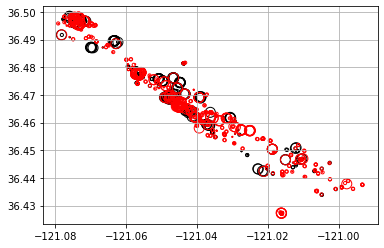

In [200]:
from notebook_functions import plotScatterMap, plotScatterMapDepth

plotScatterMap(cat_crit)

In [193]:
len(cat_crit[cat_crit.RID!='0'])

73

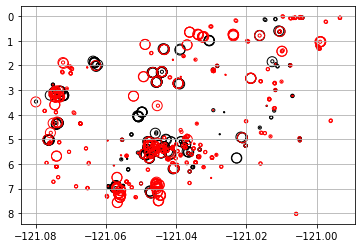

In [457]:
plotScatterMapDepth(cat_crit)





In [233]:
cat_crit.to_csv('../data/catalogs/cat_test_Rx11.csv')




# Previous grading codes

In [234]:
cat_graded = GradeLocErrorLatLon(cat,verbose=0,plot=0);

3051 2742


In [235]:
getProportionWS21(cat_graded[cat_graded.Grade!='C'],cat_WS21)

0.8544921875

In [96]:
GradeLocErrorLatLon(cat_graded,verbose=0,plot=0);

NameError: name 'cat_graded' is not defined

# With meters (for relocated catalog)

In [236]:
len(cat_WS21_reloc)

984

In [34]:
# cat = cat_WS21_reloc
cat = cat_reloc

In [35]:
minlocerr_km = 0.02; #% average min location error added to the rupture area (in km).
minlocerr_m = minlocerr_km * 1000

cat['dHorz'] = [np.max([dX,dY,minlocerr_m]) for dX,dY in zip(cat.dX, cat.dY)]
cat['locerr'] = [np.max([dX,dY,dZ,minlocerr_m]) for dX,dY,dZ in zip(cat.dX, cat.dY, cat.dZ)]
cat['dHorz2'] = [np.max([dX,dY]) for dX,dY in zip(cat.dX, cat.dY)]

cat_crit = pd.DataFrame()
plot = 0
ntype1 = 0

for cl in np.unique(cat.RID):
    
    cat_clus = cat[cat.RID==cl]

    
    x = np.array(cat_clus.X)
    y = np.array(cat_clus.Y)
    z = np.array(cat_clus.Z)
    itake1=1
    dmag = 0.1
    med_lat = np.median(cat_clus.lat)
    for j in range(len(cat_clus)):  
        xc = cat_clus.dX.iloc[j]
        yc = cat_clus.dY.iloc[j]
        zc = cat_clus.dZ.iloc[j]        

        rad_m=(calcRadius(cat_clus.magnitude.iloc[j]+dmag))
        drad = rad_m    


        dist = np.sqrt( (x-xc)**2 + (y-yc)**2 + (z-zc)**2 ) 

        inside = dist < (drad + cat_clus.locerr.iloc[j])


        # print(inside)
        if min(inside)==0:
            itake1=0
        
    if(itake1==1):
        
        ntype1= ntype1+1
        cat_crit = cat_crit.append(cat_clus)

        if plot:
            fig, [ax,ax2] = plt.subplots(ncols=2,figsize=(4,2))
            plt.subplots_adjust(wspace=.5)
            
            ax.set_title(enum)
            plotLocZoomMeters(cat_clus,cat_clus,ax=ax) 
            plotDepthZoomMeters(cat_clus,cat_clus,ax=ax2)
            # ax2.set_aspect(meters2deg(1,med_lat))
            ax2.axis('equal')
            ax.tick_params(color='g', labelcolor='g')
            for spine in ax.spines.values():
                spine.set_edgecolor('g')        

    else:
        if plot:
            fig, [ax,ax2] = plt.subplots(ncols=2,figsize=(4,2))
            plt.subplots_adjust(wspace=.5)

            ax.set_title(enum)            
            plotLocZoomMeters(cat_clus,cat_clus,ax=ax)
            plotDepthZoomMeters(cat_clus,cat_clus,ax=ax2)             
            # ax2.set_aspect(meters2deg(1,med_lat))
            ax2.axis('equal')
            ax.tick_params(color='red', labelcolor='red')
            for spine in ax.spines.values():
                spine.set_edgecolor('red')             


print(ntype1)   
print(len(cat),len(cat_crit))

89
3158 596


# Remove outside events

In [38]:
ntype1 = 0
cat_crit = pd.DataFrame()

for cl in np.unique(cat.Cluster_2):
    itake1=1


    cat_clus = cat[cat.Cluster_2==cl]
    cat_clus_keep = pd.DataFrame()
    
    x = np.array(cat_clus.X)
    y = np.array(cat_clus.Y)
    z = np.array(cat_clus.Z)
    
    for j in range(len(cat_clus)):
        row = cat_clus.iloc[j]
        index = cat_clus.index[j]
        dmag = 0.1
        rad_m=(calcRadius(row.magnitude+dmag))
        drad = rad_m
        inside = np.sqrt( (x-row.X)**2 + (y-row.Y)**2 + (z-row.Z)**2 ) < drad + row.locerr;

        if min(inside)==0:
            itake1=0
#             print('remove event')
            #             
            x = np.array(cat_clus.drop(index).X)
            y = np.array(cat_clus.drop(index).Y)
            z = np.array(cat_clus.drop(index).Z)
            

        else:
            cat_clus_keep = cat_clus_keep.append(row)
    
        
        
    if(itake1==1):
        ntype1= ntype1+1
        cat_crit = cat_crit.append(cat_clus_keep)

print(ntype1)    



250


In [ ]:



cat_crit_stats = calcDfStats(cat_crit,timeMin=0)

cat_crit_stats.magnitude.hist()

In [96]:
cat = cat_WS21

In [97]:
cat.columns

Index(['Cluster_2', 'event_ID', 'isAnyRepeater', 'YR', 'MO', 'DY', 'HR', 'MN',
       'SC', 'DAYS', 'LAT', 'LON', 'DEP', 'dX', 'dY', 'dZ', 'MAG', 'dmag',
       'dmage', 'CCm', 'evID', 'REQS_ID', 'year', 'month', 'day', 'hour',
       'minute', 'second', 'lat', 'long', 'depth_km', 'magnitude', 'timestamp',
       'RID', 'dHorz', 'locerr', 'dHorz2'],
      dtype='object')

# Adapt my code with Felix's criteria

In [ ]:
from matplotlib.ticker import FormatStrFormatter

In [200]:
cat = cat_reloc
# cat = cat_WS21_reloc

In [201]:
cat_WS21_reloc_passed = GradeFelLocErrorLatLon(cat,plot=1)

3041 710


<AxesSubplot:>

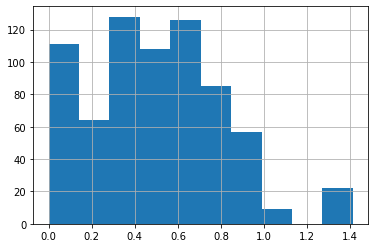